# Checking every step of preprocessing

### Imports

In [35]:
import os
import numpy as np
import tensorflow
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as ss
from scipy.stats import kurtosis, zscore
from sklearn import preprocessing
import keras
import PyQt5
from sklearn.model_selection import train_test_split
import pandas as pd
from typing import Iterable, Union
from datetime import datetime
# %matplotlib notebook
mne.set_log_level(verbose='CRITICAL')

### Functions for preprocessing

In [19]:
def get_bad_channels(signal, ch_names, percentiles = [25,75]): #shape = (channels, samples)
    channels = signal.shape[1]
    Qstd = np.std(signal,axis = -1)
    Qkurt = kurtosis(signal,axis = -1)
    bads = np.empty(0)
    Q1,Q3 = np.percentile(Qstd,percentiles)
    IQR = (Q3-Q1)*1.5
    range_std = (Q1-IQR,Q3+IQR)
    Q1,Q3 = np.percentile(Qkurt,percentiles)
    IQR = (Q3-Q1)*1.5
    range_kurt = (Q1-IQR,Q3+IQR)
    right_std = np.where(Qstd > range_std[1])[0]
    left_std = np.where(Qstd < range_std[0])[0]
    right_kurt = np.where(Qkurt > range_kurt[1])[0]
    left_kurt = np.where(Qkurt < range_kurt[0])[0]
    bads = np.unique(np.concatenate((bads,left_kurt,right_kurt,left_std,right_std)))
    return bads.astype(int), np.array(ch_names)[bads.astype(int)]

def get_bad_epochs(signal,percentiles = [25,75]): #shape = ( epochs, channels, samples)
    channels = signal.shape[1]
    Qstd = np.std(signal,axis = -1)
    Qkurt = kurtosis(signal,axis = -1)
    bads = np.empty(0)
    for i in range(channels):
        Q1,Q3 = np.percentile(Qstd[:,i],percentiles)
        IQR = (Q3-Q1)*1.5
        range_std = (Q1-IQR,Q3+IQR)
        Q1,Q3 = np.percentile(Qkurt[:,i],percentiles)
        IQR = (Q3-Q1)*1.5
        range_kurt = (Q1-IQR,Q3+IQR)
        right_std = np.where(Qstd[:,i] > range_std[1])[0]
        left_std = np.where(Qstd[:,i] < range_std[0])[0]
        right_kurt = np.where(Qkurt[:,i] > range_kurt[1])[0]
        left_kurt = np.where(Qkurt[:,i] < range_kurt[0])[0]
        bads = np.unique(np.concatenate((bads,left_kurt,right_kurt,left_std,right_std)))
    return bads

def RMS(signal, window_size):
    signal2 = signal**2
    window = np.ones(window_size)/window_size
    return np.sqrt(np.convolve(signal2, window, 'same'))

def RMS_epochs(epochs,window_length=32): #(epochs, channels, samples)
    return np.apply_along_axis(RMS,-1,epochs,window_length)

def before_after_plot(before_data, after_data, fs, channel, ch_name, name, start = 150, stop = 250, Fs_new = None): 
    time = np.arange(start,stop,1/fs)
    
    plt.figure(figsize = (13,5))
    plt.subplot(1,2,1)
    plt.plot(time, before_data[channel,start*fs:stop*fs])
    plt.title(f'Channel {ch_name}, before ' + name)
    plt.xlabel('time [s]')
    
    ratio = 1
    if Fs_new:
        ratio = int(fs/Fs_new)
        time = np.arange(start, stop, 1/(fs/ratio))
        
    plt.subplot(1,2,2)
    plt.plot(time, after_data[channel,start*fs//ratio:stop*fs//ratio])
    plt.title(f'Channel {ch_name}, after ' + name)
    plt.xlabel('time [s]')
    plt.show()
    
def plot_mean_welch(epochs, fs, names, xlim = None, ylim = None):
    no_bands = len(names)
    plt.figure(figsize = (11,10))
    f, welch = ss.welch(epochs, fs=fs, axis = -1)
    mean_welch = np.mean(welch, axis = (1,2))
    for i in range(no_bands):
        plt.subplot(no_bands,1,i+1)
        plt.title(names[i])
        plt.plot(f,mean_welch[i,:])
        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)
    plt.tight_layout()
    plt.show()
    
def preprocess(filename: str, fmin: Union[float, int], fmax: Union[float, int], 
               method: str, down_fs: Union[float, int], 
               tmin: Union[float, int], tmax: Union[float, int], exclude_ratio: Union[float, int], 
               method_bands: str, bands: Iterable[Iterable[Union[int, float]]], verbose: any):
    if verbose == False:
        mne.set_log_level(verbose = 'CRITICAL')
    else:
        mne.set_log_level(verbose = None)
    
    '''Reading file'''
    file = mne.io.read_raw_eeglab(filename ,preload = True)
    
    '''Setting reference'''
    file.set_eeg_reference(ref_channels = ['A1','A2']) 
    
    '''Dropping unncessary channels'''
    file.drop_channels(['EOG','dioda','TSS','A1','A2'])
    
    '''Params'''
    Fs = int(file.info['sfreq'])
    channels = file.info['ch_names']
    
    '''First filtering'''
    file.filter(fmin, fmax, method = method, iir_params = dict(order=5, ftype='butter'))
    
    '''Finding and interpolating bad channels'''
    ch_ind, ch_names = get_bad_channels(file.get_data(), channels)
    file.info['bads'] = ch_names
    file.interpolate_bads(reset_bads = False, mode = 'accurate', origin = [0,0,0])
    
    '''Downsampling'''
    file.resample(down_fs)
    
    '''Marking events'''
    ratio = Fs//down_fs
    count = len(file.event['latency'])
    EVENTS = np.zeros((count,3))
    EVENTS[:,0] = file.event['latency']
    EVENTS[:,1] = 0
    EVENTS[:,2] = 1
    EVENTS = EVENTS/ratio
    
    '''Creating epochs'''
    epo = mne.Epochs(file, EVENTS.astype(int), metadata = pd.DataFrame(file.event['tag_type']), 
                     tmin = tmin, tmax = tmax, preload = True)
    
    '''Epoch params'''
    samples = len(epo._raw_times)
    time = epo._raw_times
    trials_count = len(epo.selection)
    nchan = epo.info['nchan']
    
    '''Dropping mistaken trials'''
    mistakes = np.array([True if i['word_type'] != i['decision'] else False for i in file.event['tag_type']])
    epo.drop(mistakes)
    
    '''Dropping bad epochs'''
    bad_epo = get_bad_epochs(epo.get_data())
    '''Excluding participant with more than half trials bad'''
    if len(bad_epo) >= trials_count//exclude_ratio:
        return False
    epo.drop(get_bad_epochs(epo.get_data()))
    
    '''Extracting frequency bands
       Hilbert envelope + tukey window'''
    no_bands = len(bands)
    trials_count = len(epo.selection)
    epochs = np.empty((no_bands, trials_count, nchan, samples))
    alpha = 0.25
    
    for ind, band in enumerate(bands):
        epochs[ind] = epo.copy().filter(band[0], band[1] ,method = method_bands, iir_params = dict(order=5, ftype='butter')).get_data()
        window = ss.tukey(samples, alpha)
        epochs[ind,:,:,:] = np.abs(ss.hilbert(epochs[ind,:,:,:] * window , axis = -1))
        alpha -= 0.05

    '''Baseline correction'''
    end_point = int(0.2*down_fs)
    epochs = (epochs - np.mean(epochs[:,:,:,:end_point], axis = (1,3)).reshape(no_bands,1,nchan,1) ) / np.std(epochs[:,:,:,:end_point], axis = (1,3)).reshape(no_bands,1,nchan,1)
    return epochs

### First step: reading data (using mne)

In [8]:
participant = 'k1'
file = mne.io.read_raw_eeglab('./data2/'+participant+'.set', preload=True)
before_ref = file.get_data() #extracting data before setting refrence channels to see any changes

'''Setting refrence channels (ears)'''
file.set_eeg_reference(ref_channels=['A1','A2']) 
after_ref = file.get_data() #extracting data after setting refrence (checking changes)

'''Dropping (removing) redundant channels'''
file.drop_channels(['EOG','dioda','TSS','A1','A2'])

<RawEEGLAB | k1.fdt, 19 x 4466688 (4362.0 s), ~647.5 MB, data loaded>

Plotting changes for refrence channels

https://mne.tools/dev/generated/mne.set_eeg_reference.html

It uses average in default

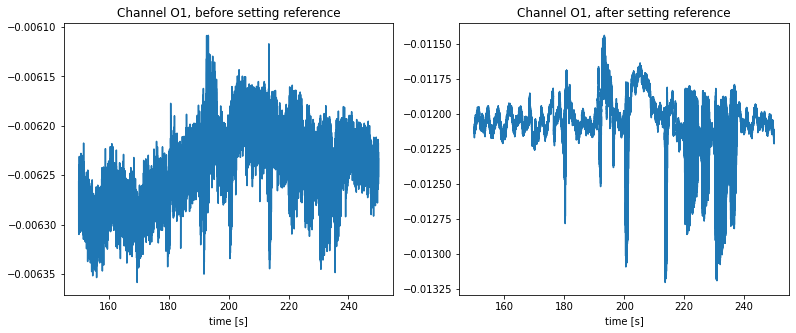

In [9]:
Fs = int(file.info['sfreq'])
channels = file.info['ch_names']
ch = 0

before_after_plot(before_ref, after_ref, Fs, ch, channels[ch], name = 'setting reference')

### Second step: Filtering

#### Checking impulse response

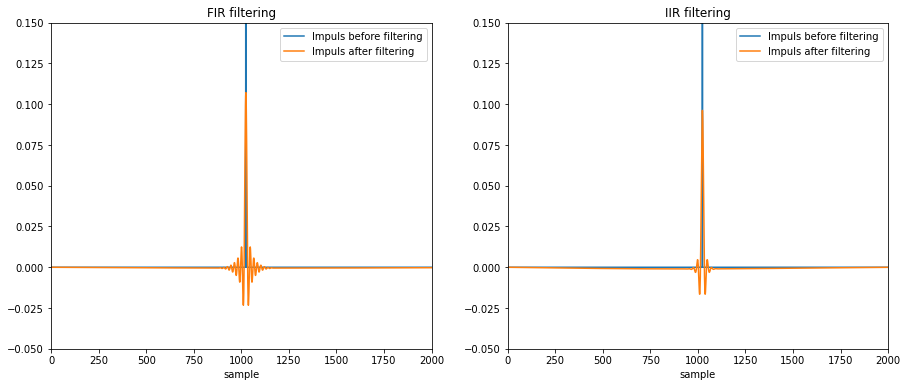

In [10]:
mne.set_log_level(verbose='CRITICAL')
'''FIR method'''
impulse = np.zeros(10*Fs)
impulse[1*Fs] = 1
impulse[5*Fs] = 1
impulse[8*Fs] = 1
filt_imp = mne.filter.filter_data(impulse,Fs,0.5,49) #default is fir method

plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
plt.xlim(0,2000)
plt.ylim(-0.05,0.15)
plt.plot(impulse, label = 'Impuls before filtering')
plt.plot(filt_imp, label = 'Impuls after filtering')
plt.xlabel('sample')
plt.title('FIR filtering')
plt.legend(loc = 'upper right')

'''IIR method'''
impulse = np.zeros(10*Fs)
impulse[1*Fs] = 1
impulse[5*Fs] = 1
impulse[8*Fs] = 1
filt_imp = mne.filter.filter_data(impulse,Fs,0.5,49,method='iir',iir_params=dict(order=5, ftype='butter'))

plt.subplot(1,2,2)
plt.xlim(0,2000)
plt.ylim(-0.05,0.15)
plt.plot(impulse, label = 'Impuls before filtering')
plt.plot(filt_imp, label = 'Impuls after filtering')
plt.title('IIR filtering')
plt.xlabel('sample')
plt.legend(loc = 'upper right')
plt.show()

### Maybe IIR mehod will be better because of shorter impulse response?

## Filtering data

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 49 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 0.50, 49.00 Hz: -6.02, -6.02 dB



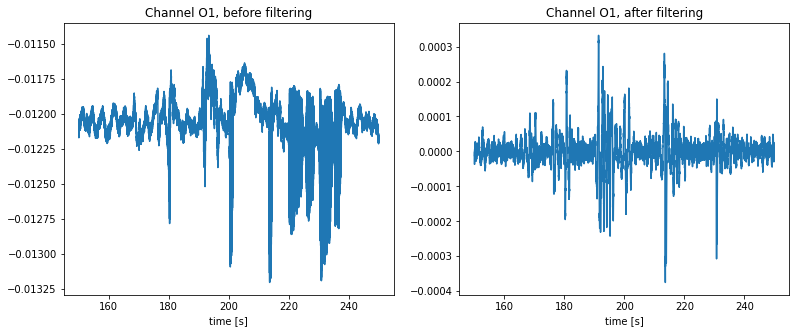

In [11]:
mne.set_log_level(verbose=None) #for mne to tell us specification of filters

before_filtering = after_ref

file.filter(0.5,49,method='iir',iir_params=dict(order=5, ftype='butter'))

after_filtering = file.get_data()

before_after_plot(before_filtering, after_filtering, Fs, ch, channels[ch], name = 'filtering')

## Interpolating

https://mne.tools/dev/overview/implementation.html#channel-interpolation

Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors


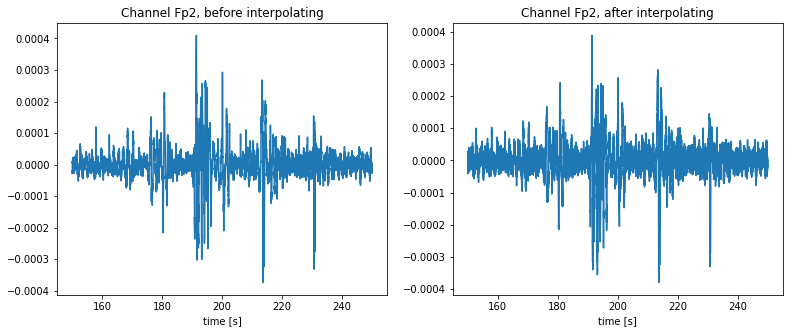

In [12]:
before_interp = after_filtering

ch_ind, ch_names = get_bad_channels(before_interp, channels)
file.info['bads'] = ch_names
file.interpolate_bads(reset_bads=False, mode='accurate', origin=[0,0,0])

after_interp = file.get_data()
ch_no = ch_ind[1]

before_after_plot(before_interp, after_interp, Fs, ch_no, channels[ch_no], name = 'interpolating')

## Downsampling

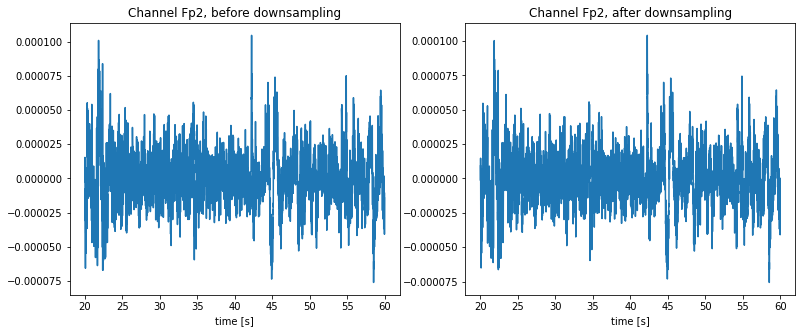

In [13]:
before_resamp = after_interp

file.resample(256)

after_resamp = file.get_data()

Fs_d = int(file.info['sfreq'])
ch_no = ch_ind[1]

before_after_plot(before_resamp, after_resamp, Fs, ch_no, channels[ch_no], name = 'downsampling', start = 20, stop = 60, Fs_new = Fs_d)

## Epochs preprocessing

#### Marking events

In [14]:
ile = len(file.event['latency'])
EVENTS = np.zeros((ile,3))
EVENTS[:,0] = file.event['latency']
EVENTS[:,1] = 0
EVENTS[:,2] = 1
EVENTS = EVENTS/4

#### Dropping bad trials

In [15]:
mne.set_log_level(verbose='CRITICAL')
epo = mne.Epochs(file, EVENTS.astype(int), metadata = pd.DataFrame(file.event['tag_type']), 
                 tmin= -0.2, tmax=1, preload=True)

mistakes = np.array([True if i['word_type']!=i['decision'] else False for i in file.event['tag_type']])
epo.drop(mistakes)

epo.drop(get_bad_epochs(epo.get_data()))

<Epochs  |   804 events (all good), -0.199219 - 1 sec, baseline [None, 0], ~36.0 MB, data loaded, with metadata,
 '0': 804>

#### Params

In [16]:
samples = len(epo._raw_times)
time = epo._raw_times
trials_count = len(epo.selection)
nchan = epo.info['nchan']

## Extracting frequency bands from epochs

In [17]:
mne.set_log_level(verbose=None)

no_bands = 5
method = 'iir'
#wyćwiczone na wszystkich - wyzerować któreś i tak sprawdzić
epoki = np.empty((no_bands, trials_count, nchan, samples))

epoki[0] = epo.copy().filter(0.5,4,method=method,iir_params=dict(order=5, ftype='butter')).get_data()
epoki[1] = epo.copy().filter(4,9,method=method,iir_params=dict(order=5, ftype='butter')).get_data()
epoki[2] = epo.copy().filter(9,14,method=method,iir_params=dict(order=5, ftype='butter')).get_data()
epoki[3] = epo.copy().filter(14,30,method=method,iir_params=dict(order=5, ftype='butter')).get_data()
epoki[4] = epo.copy().filter(30,49,method=method,iir_params=dict(order=5, ftype='butter')).get_data()

Setting up band-pass filter from 0.5 - 4 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 0.50, 4.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 9 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 4.00, 9.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 9 - 14 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 9.00, 14.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 14 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (ef

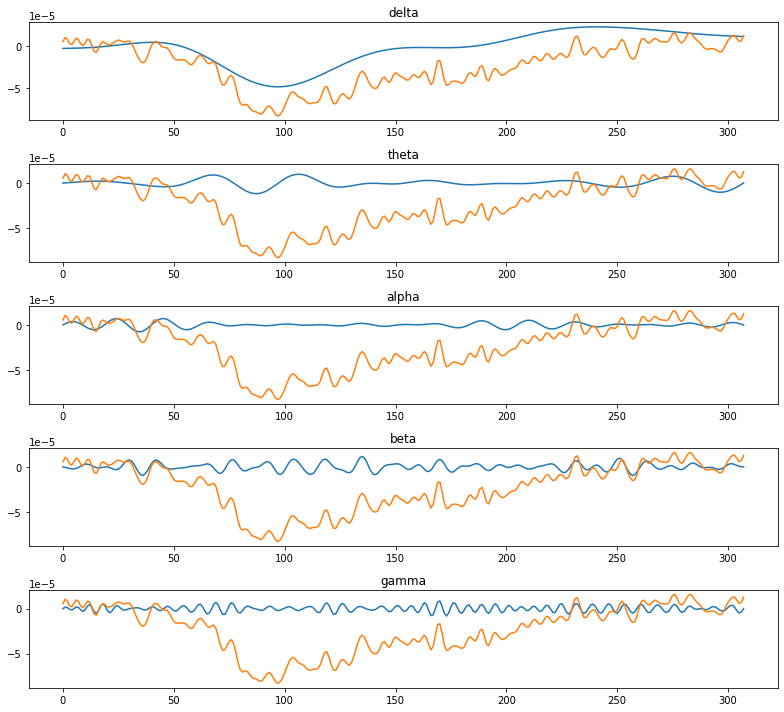

In [18]:
plt.figure(figsize = (11,10))
band_names = ('delta','theta','alpha','beta','gamma')
epo_before = epo.get_data()

for i in range(no_bands):
    plt.subplot(no_bands,1,i+1)
    plt.title(band_names[i])
    plt.plot(epoki[i,0,0,:])
    plt.plot(epo_before[0,0,:])
plt.tight_layout()
plt.show()

## Hilber envelope + tukey window

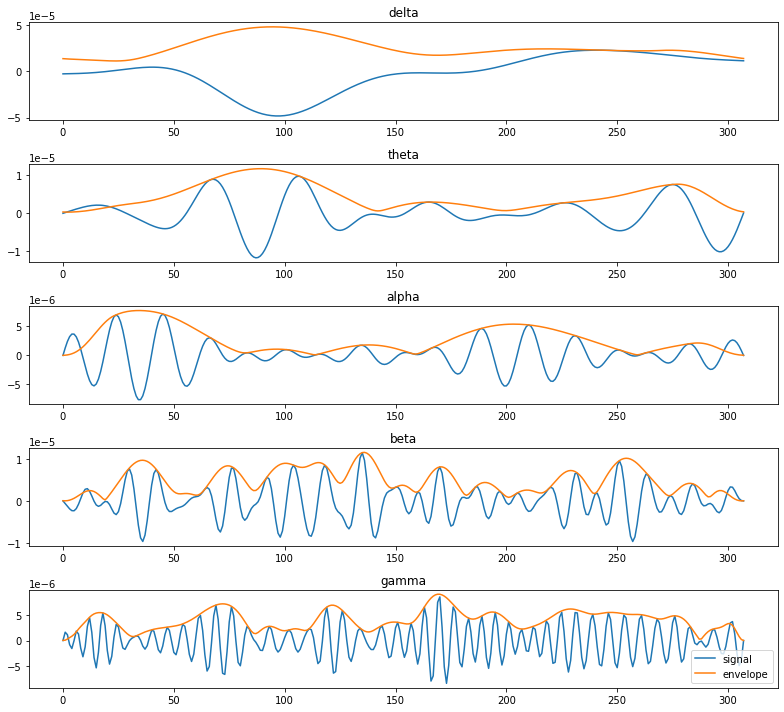

In [26]:
plt.figure(figsize = (11,10))
end_point = int(0.2*Fs_d)
alpha = 0.25
hilb_epo = epoki.copy()
nepo = 0
nch = 0

for i in range(no_bands):
    window = ss.tukey(samples, alpha)
    hilb_epo[i,:,:,:] = np.abs(ss.hilbert(hilb_epo[i,:,:,:] * window , axis = -1))
    hilb_i = hilb_epo[i,nepo,nch,:]
    plt.subplot(no_bands,1,i+1)
    plt.title(band_names[i])
    plt.plot(epoki[i,nepo,nch,:], label = 'signal')
    plt.plot(hilb_i, label = 'envelope')
    alpha -= 0.05
plt.legend()
plt.tight_layout()
plt.show()

## Baseline correction

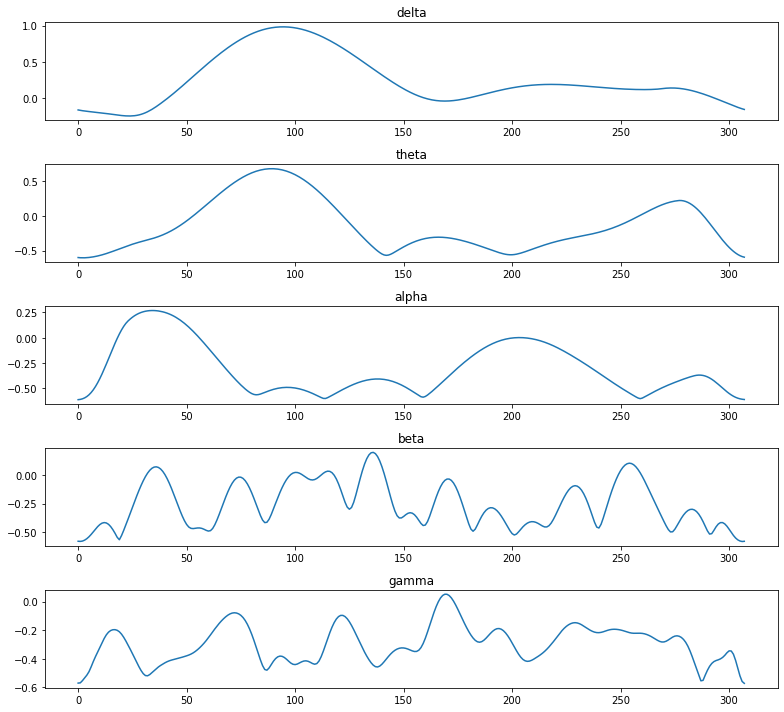

In [29]:
plt.figure(figsize = (11,10))
end_point = int(0.2*Fs_d)
hilb_epo_base = hilb_epo.copy()
hilb_epo_base = (hilb_epo_base - np.mean(hilb_epo_base[:,:,:,:end_point], axis = (1,3)).reshape(5,1,19,1) ) / np.std(hilb_epo_base[:,:,:,:end_point], axis = (1,3)).reshape(5,1,19,1)
for i in range(no_bands):
    norm_i = hilb_epo_base[i,nepo,nch,:]
#     norm_i2 = (hilb_epo[i,nepo,nch,:end_point] - np.mean(hilb_epo[i,:,nch,:end_point]) ) / np.std(hilb_epo[i,:,nch,:end_point])
    plt.subplot(no_bands,1,i+1)
    plt.title(band_names[i])
    plt.plot(norm_i)
#     plt.plot(norm_i2)
    
plt.tight_layout()
plt.show()

## Mean welch - whole participant

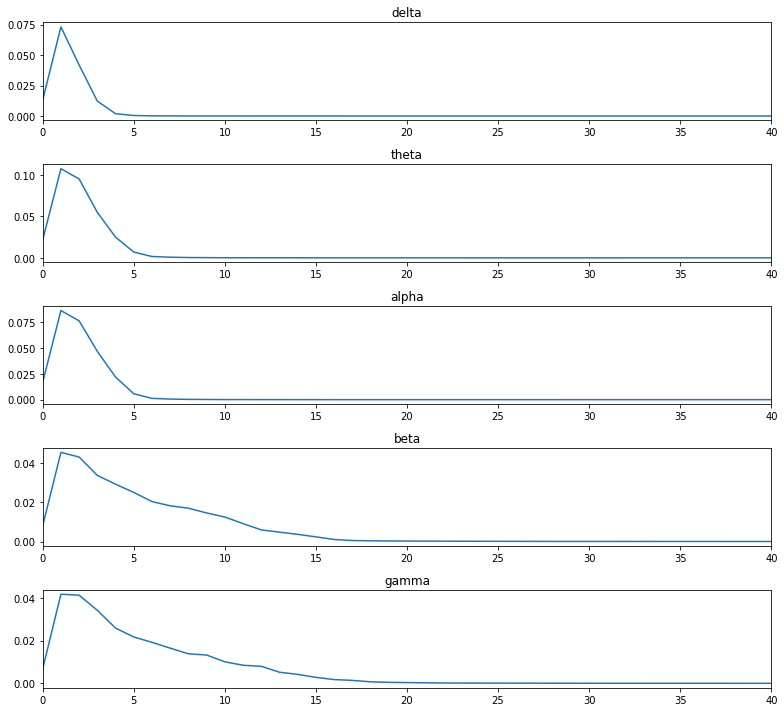

In [21]:
plot_mean_welch(hilb_epo_base, Fs_d, band_names) 

## Resampling vol 2

<Figure size 792x720 with 0 Axes>

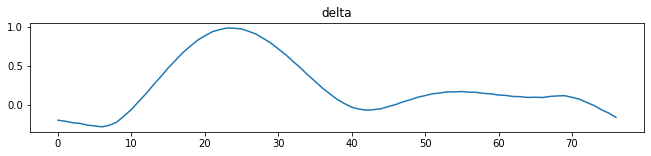

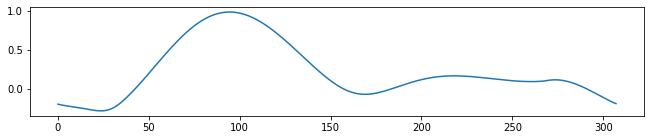

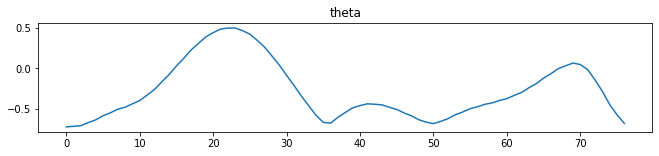

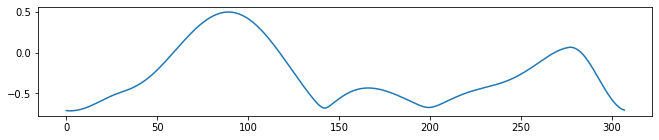

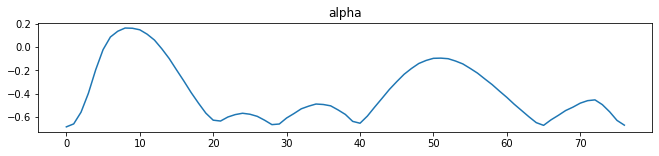

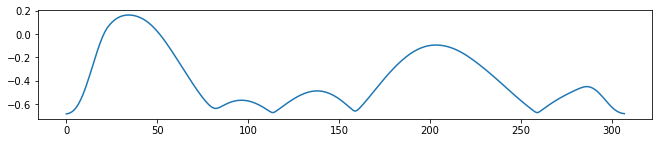

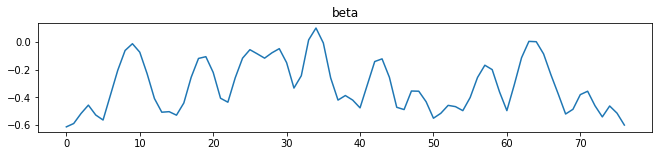

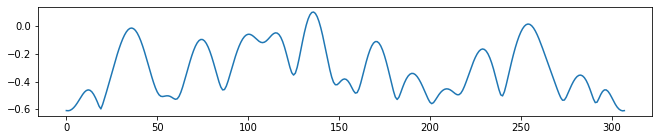

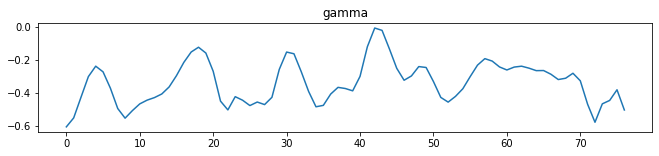

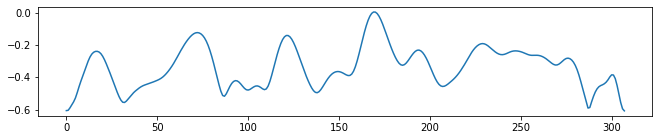

<Figure size 432x288 with 0 Axes>

In [24]:
plt.figure(figsize = (11,10))
end_point = int(0.2*Fs)
epo_final = mne.filter.resample(hilb_epo_base.copy(), up = 1, down = 4)
for i in range(no_bands):
    plt.figure(figsize = (11,2))
    plt.title(band_names[i])
    plt.plot(epo_final[i,nepo,nch,:])
    plt.show()
    plt.figure(figsize = (11,2))
    plt.plot(hilb_epo_base[i,nepo,nch,:])
    plt.show()
plt.tight_layout()
plt.show()

FS = Fs_d//4

In [ ]:
#zwykła konwolucyjna sieć - obrazek czas x czestosc, kanały RGB - elektrody
#zbiory uczące - potem będziemy składać sieci
#zbiory - 2 sposoby jak je budować (od Mateusza)
#widmo - spr do jakiej częstości obciąć (z tego co wychodzi z abs hilberta), 6 razy mniej (?)
#kilka próbek od kilku pacjentów

In [11]:
bands = [(0.5,4), (4,9), (9,14), (14,3), (30,49)]
band_names = ('delta','theta','alpha','beta','gamma')

participant = 'm1'
a = datetime.now()
Epochs = preprocess('./data2/'+participant+'.set', 
                    fmin = 0.5, fmax = 49, 
                    method = 'iir', 
                    down_fs = 256, 
                    tmin = -0.2, tmax = 1, 
                    exclude_ratio = 2, 
                    method_bands = 'iir', 
                    bands = bands,
                    verbose = False)
b = datetime.now()
print((b-a).total_seconds())
print((b-a).total_seconds()/60)

48.448245
0.80747075


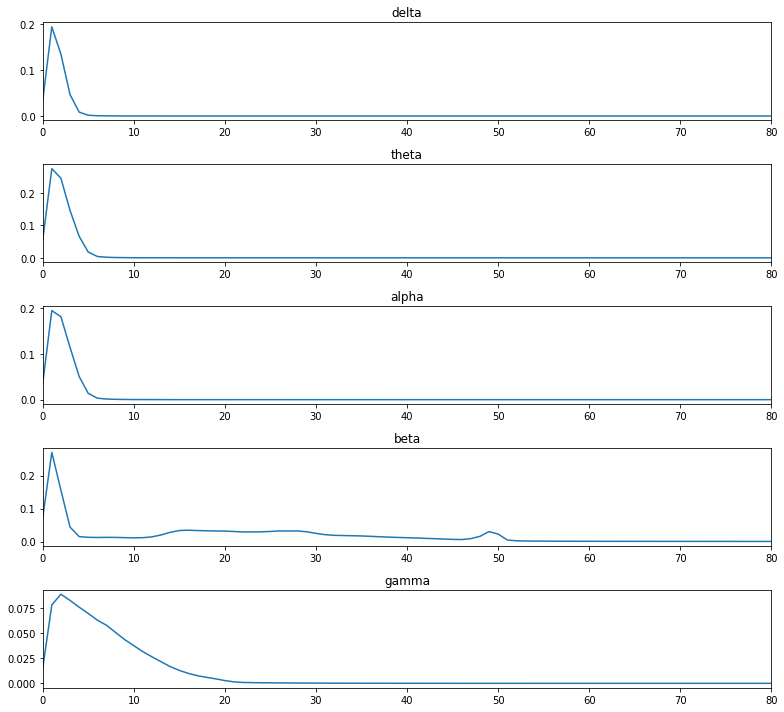

In [20]:
plot_mean_welch(Epochs, 256, band_names, xlim = (0,80)) 

48.739644
0.8123273999999999
m2


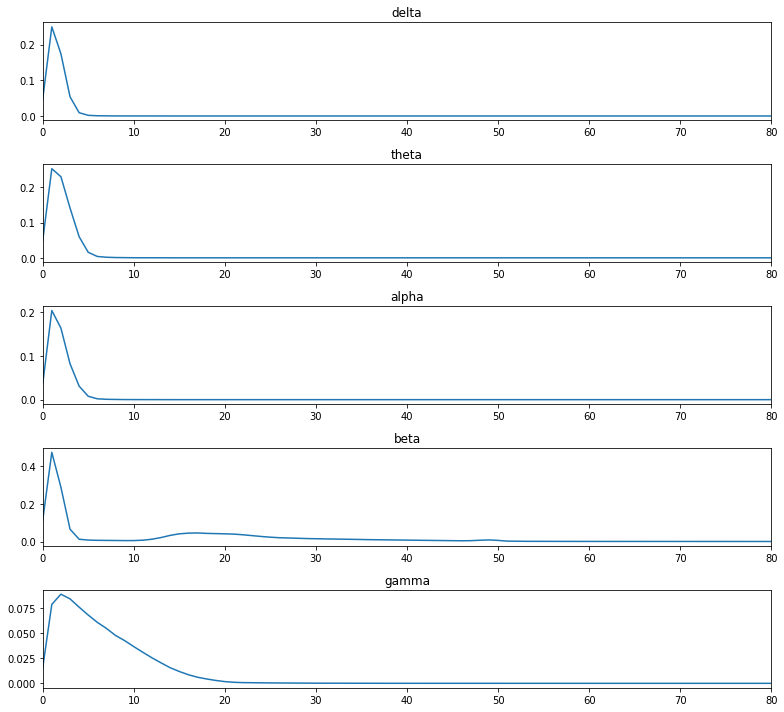

49.284936
0.8214156
m3


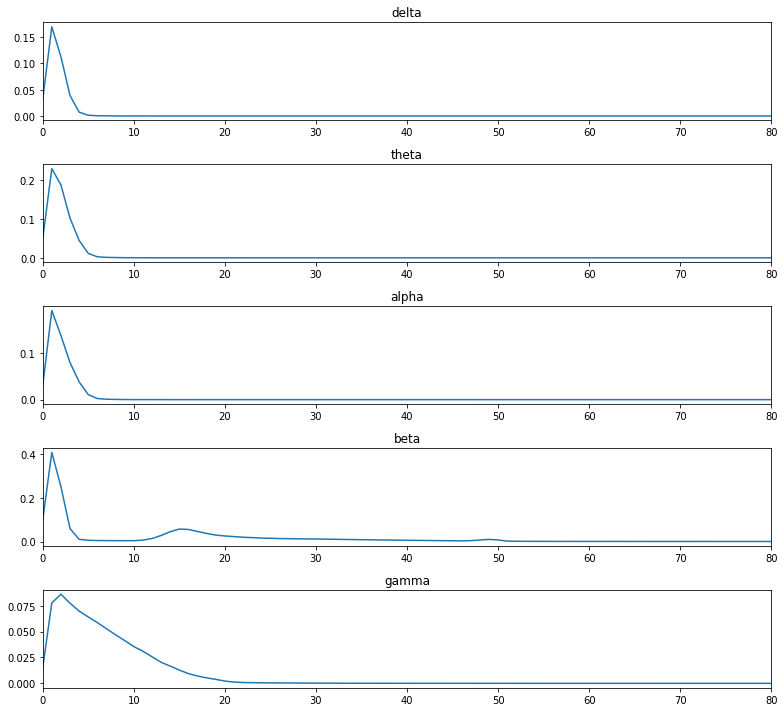

45.950793
0.7658465499999999
m4


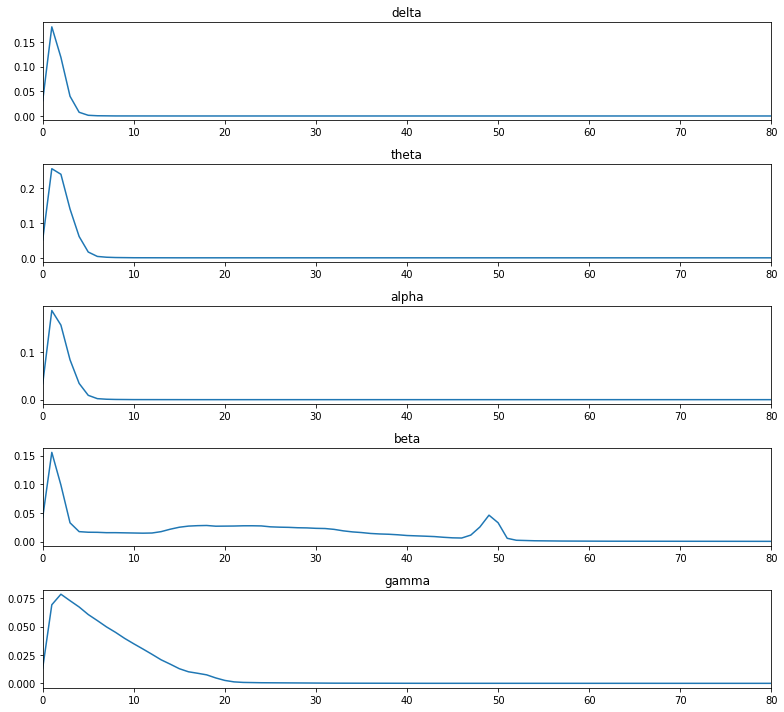

48.503411
0.8083901833333333
m7


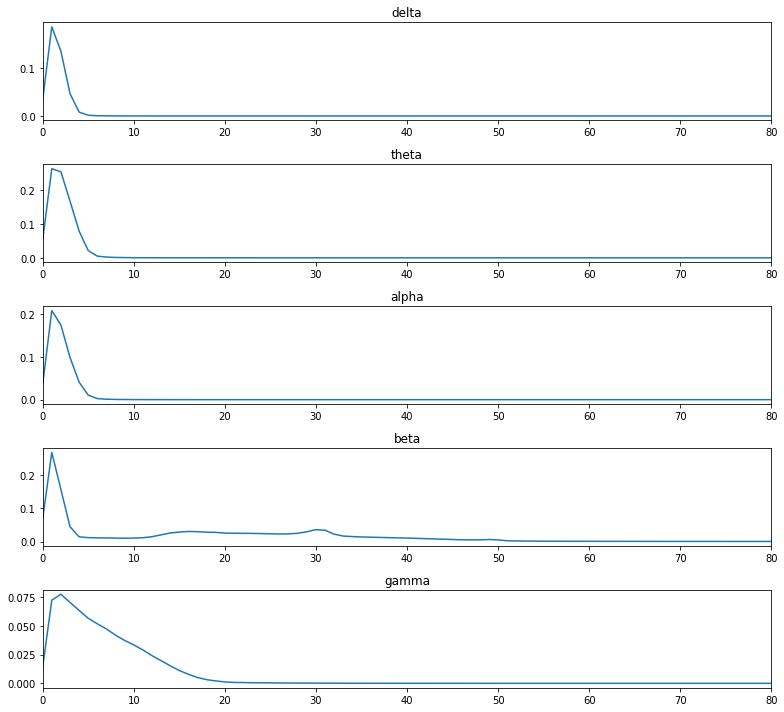

41.606574
0.6934429000000001
k2


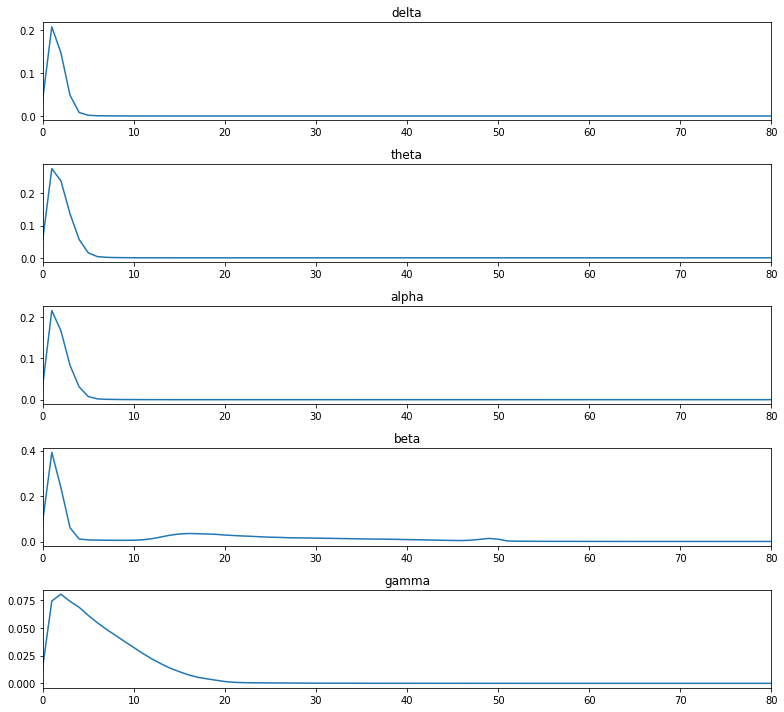

46.781276
0.7796879333333333
k8


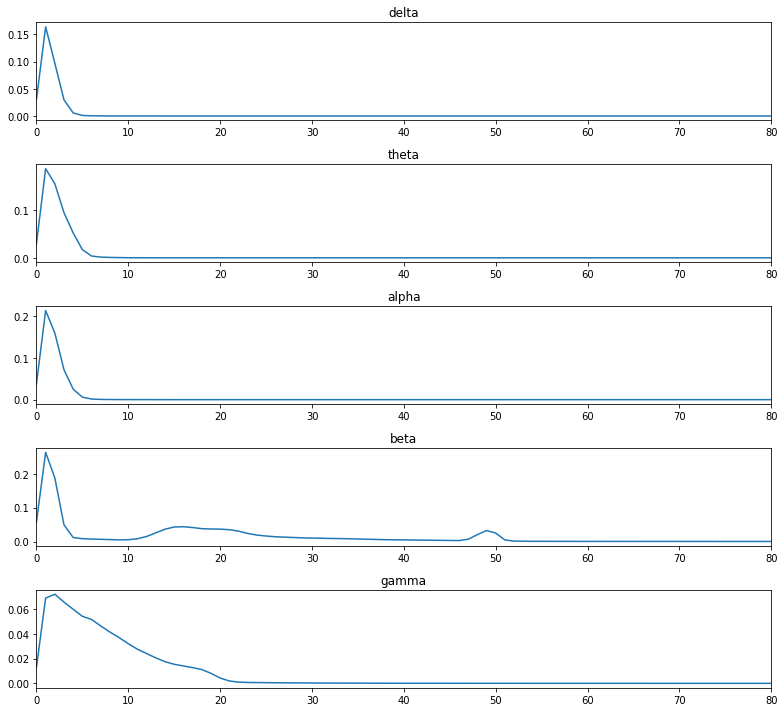

49.585446
0.8264241
k10


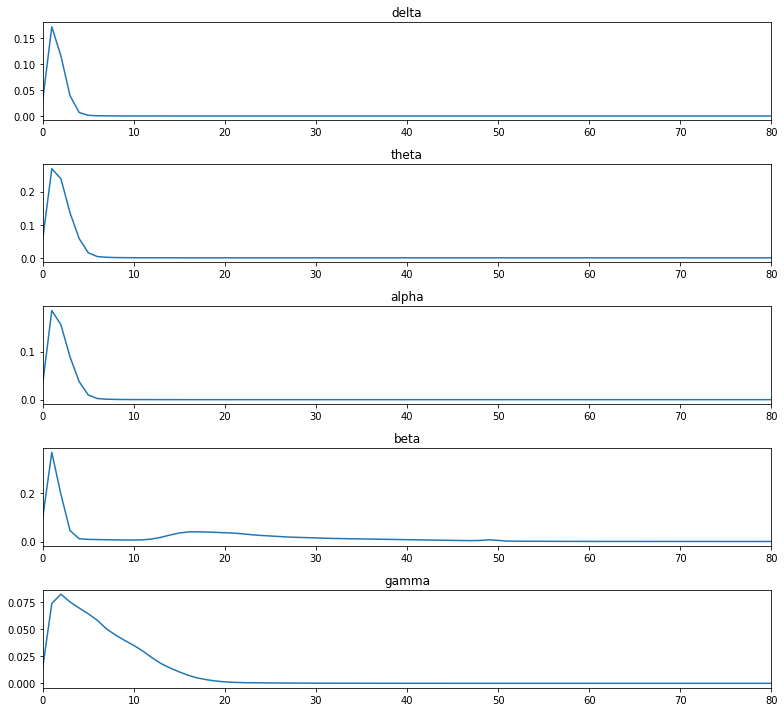

337.140499
5.619008316666666


In [39]:
participants = ['m2', 'm3', 'm4', 'm7', 'k2', 'k8', 'k10']
A = datetime.now()
for particip in participants:
    a = datetime.now()
    Epochs = preprocess('./data2/'+particip+'.set', 
                        fmin = 0.5, fmax = 49, 
                        method = 'iir', 
                        down_fs = 256, 
                        tmin = -0.2, tmax = 1, 
                        exclude_ratio = 2, 
                        method_bands = 'iir', 
                        bands = bands,
                        verbose = False)
    b = datetime.now()
    print((b-a).total_seconds())
    print((b-a).total_seconds()/60)
    print(particip)
    if isinstance(Epochs, np.ndarray):
        plot_mean_welch(Epochs, 256, band_names, xlim = (0,80)) 
    else: 
        print(f'NIE DOBRY PARTICIPANT, WIECEJ NIZ POLOWA ODPADLA:' + particip)
B = datetime.now()
print((B-A).total_seconds())
print((B-A).total_seconds()/60)

46.382447
0.7730407833333334
m2


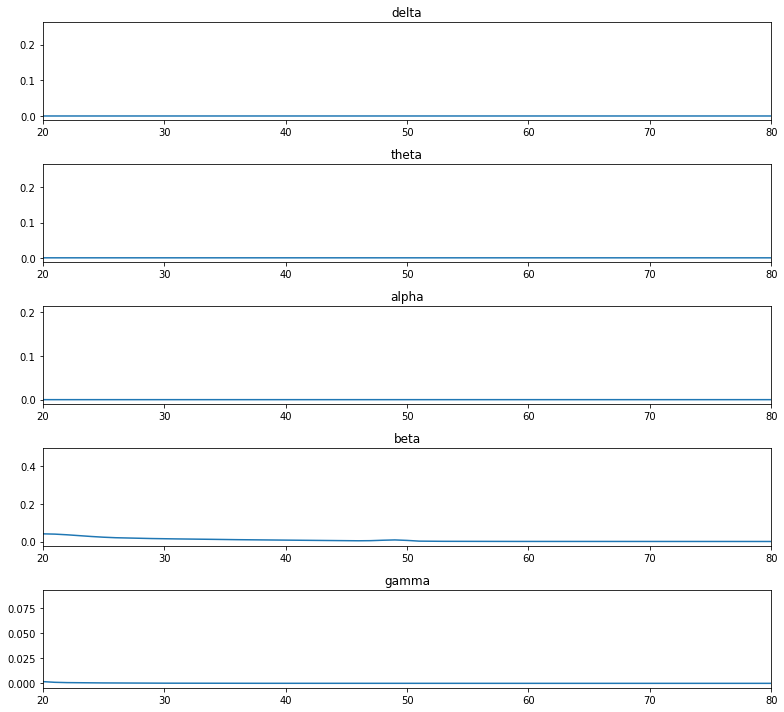

47.773626
0.7962271
m3


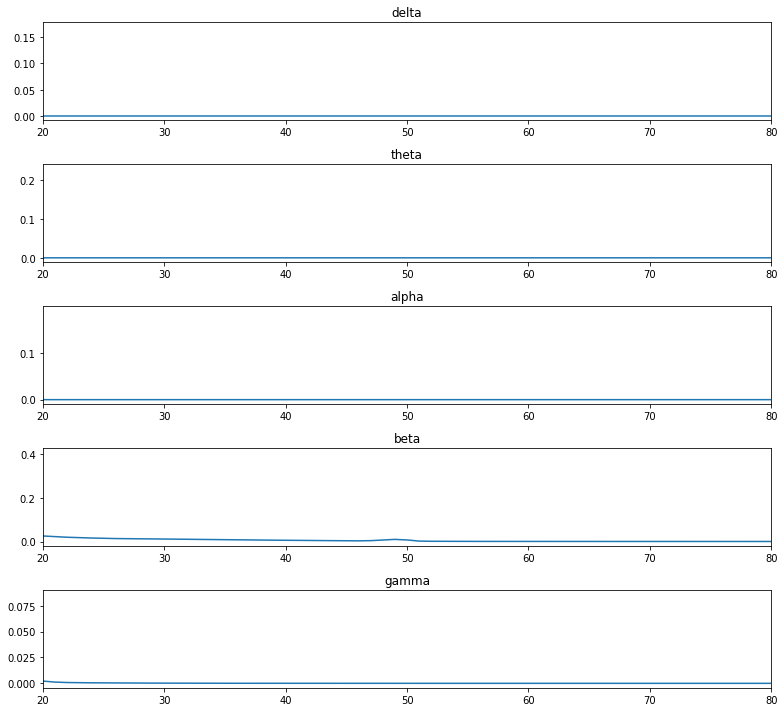

46.719673
0.7786612166666667
m4


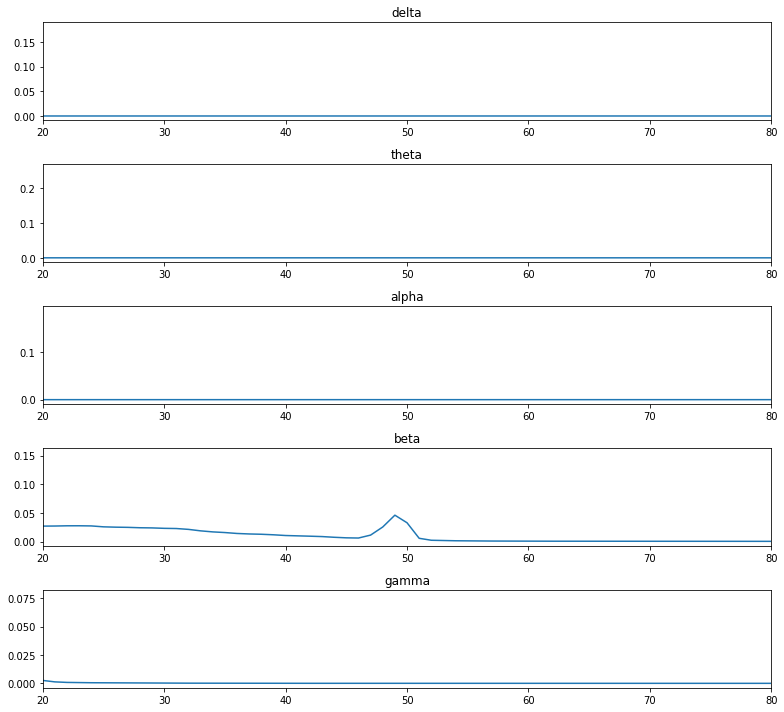

47.238434
0.7873072333333333
m7


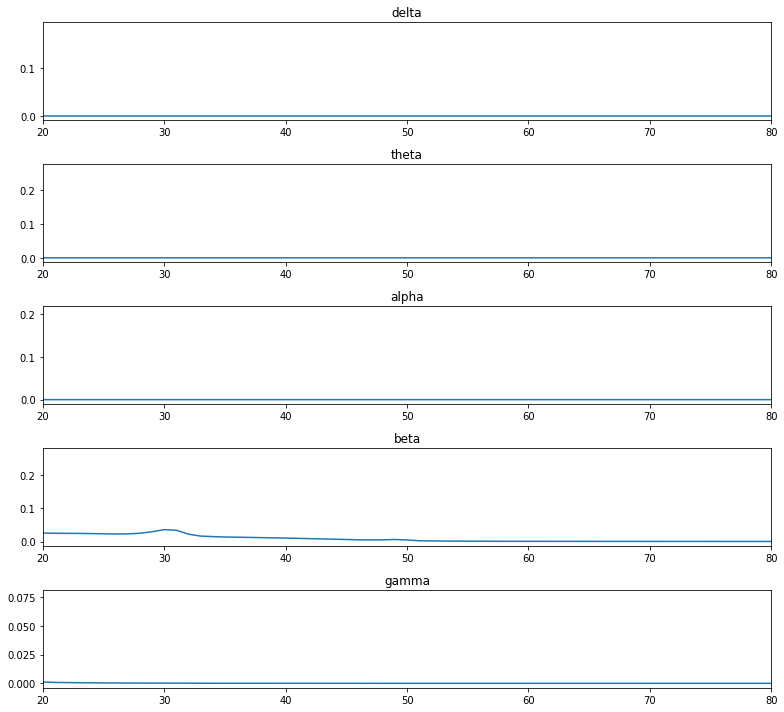

41.84593
0.6974321666666667
k2


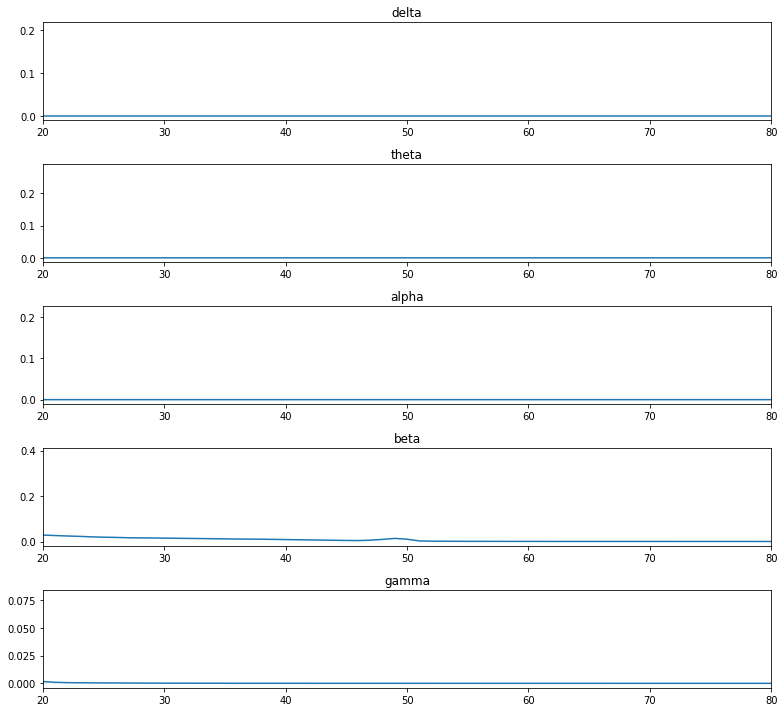

45.838049
0.7639674833333333
k8


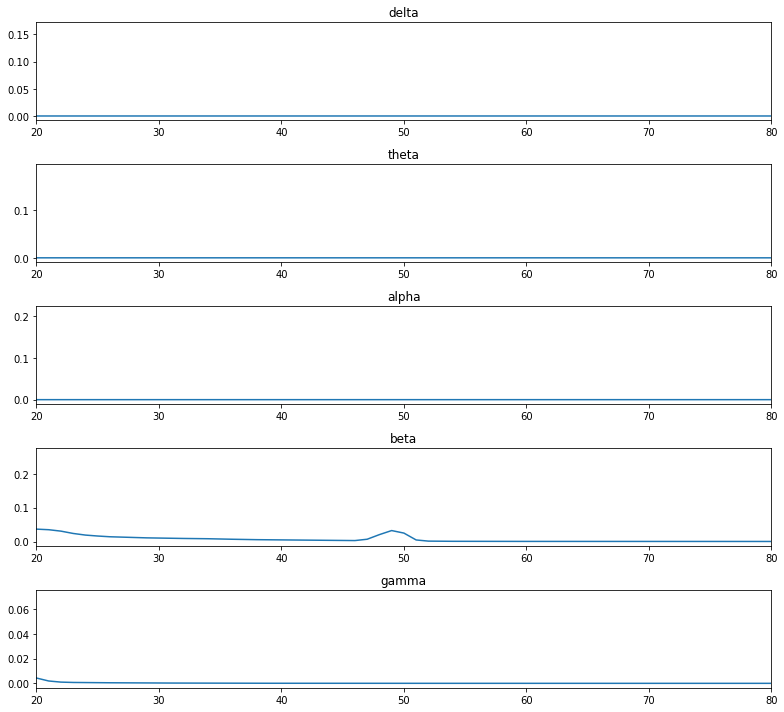

48.009999
0.80016665
k10


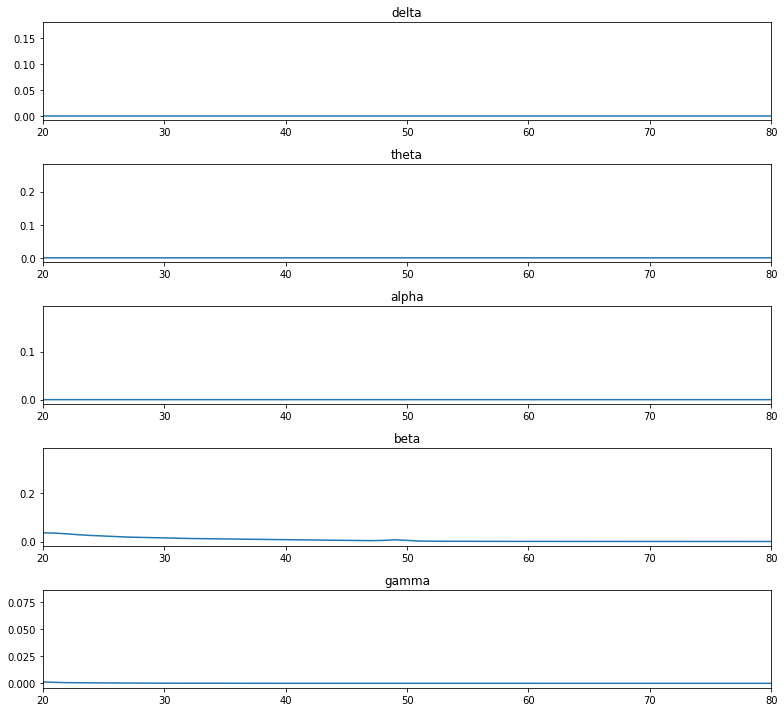

330.678501
5.511308349999999


In [40]:
participants = ['m2', 'm3', 'm4', 'm7', 'k2', 'k8', 'k10']
A = datetime.now()
for particip in participants:
    a = datetime.now()
    Epochs = preprocess('./data2/'+particip+'.set', 
                        fmin = 0.5, fmax = 49, 
                        method = 'iir', 
                        down_fs = 256, 
                        tmin = -0.2, tmax = 1, 
                        exclude_ratio = 2, 
                        method_bands = 'iir', 
                        bands = bands,
                        verbose = False)
    b = datetime.now()
    print((b-a).total_seconds())
    print((b-a).total_seconds()/60)
    print(particip)
    if isinstance(Epochs, np.ndarray):
        plot_mean_welch(Epochs, 256, band_names, xlim = (20,80)) 
    else: 
        print(f'NIE DOBRY PARTICIPANT, WIECEJ NIZ POLOWA ODPADLA:' + particip)
B = datetime.now()
print((B-A).total_seconds())
print((B-A).total_seconds()/60)